In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 40.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Encoding and Tokenizing Label

In [5]:
train_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/train_df.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/validation_df.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/test_df.pkl')

In [6]:
# getting the training, validation, and test text
train_text = train_df['lyrics'].tolist()
validation_text = validation_df['lyrics'].tolist()
test_text = test_df['lyrics'].tolist()

In [7]:
# getting the training, validation, and test label
train_label = train_df['mapped_genres'].tolist()
validation_label = validation_df['mapped_genres'].tolist()
test_label = test_df['mapped_genres'].tolist()

In [8]:
# getting rid of \n in the lyrics column
def preprocess_text(text):
  return text.replace('\n', ' ')

train_text = [preprocess_text(text) for text in train_text]
validation_text = [preprocess_text(text) for text in validation_text]
test_text = [preprocess_text(text) for text in test_text]

In [9]:
# encoding the labels
encode_label = LabelEncoder()
train_label = encode_label.fit_transform(train_label)
validation_label = encode_label.fit_transform(validation_label)
test_label = encode_label.fit_transform(test_label)

In [10]:
# initializeing TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features= 10000)

# fit and transform the text
X_train = tfidf_vectorizer.fit_transform(train_text)
X_val = tfidf_vectorizer.transform(validation_text)
X_test = tfidf_vectorizer.transform(test_text)

In [11]:
# scaling tf-idf feature
scaler = StandardScaler(with_mean = False)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

# Bert Embedding

In [12]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

#X_train_bert = np.array([get_bert_embedding(text) for text in train_text])
#X_val_bert = np.array([get_bert_embedding(text) for text in validation_text])
#X_test_bert = np.array([get_bert_embedding(text) for text in test_text])

#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert.npy', X_train_bert)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_val_bert.npy', X_val_bert)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_test_bert.npy', X_test_bert)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
chunks = np.array_split(train_text, 5)

In [ ]:
#X_train_bert_0 = np.array([get_bert_embedding(text) for text in chunks[0]])
#X_train_bert_1 = np.array([get_bert_embedding(text) for text in chunks[1]])
#X_train_bert_2 = np.array([get_bert_embedding(text) for text in chunks[2]])
#X_train_bert_3 = np.array([get_bert_embedding(text) for text in chunks[3]])
#X_train_bert_4 = np.array([get_bert_embedding(text) for text in chunks[4]])

#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_0.npy', X_train_bert_0)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_1.npy', X_train_bert_1)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_2.npy', X_train_bert_2)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_3.npy', X_train_bert_3)
#np.save('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_4.npy', X_train_bert_4)

In [14]:
X_train_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert.npy')
X_val_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_val_bert.npy')
X_test_bert = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_test_bert.npy')

In [15]:
X_train_bert_0 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_0.npy')
X_train_bert_1 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_1.npy')
X_train_bert_2 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_2.npy')
X_train_bert_3 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_3.npy')
X_train_bert_4 = np.load('/content/drive/MyDrive/w266/266 Final Project/Music4all Dataset/X_train_bert_4.npy')

In [16]:
X_train_bert_0 = np.squeeze(X_train_bert_0, axis=1)
X_train_bert_1 = np.squeeze(X_train_bert_1, axis=1)
X_train_bert_2 = np.squeeze(X_train_bert_2, axis=1)
X_train_bert_3 = np.squeeze(X_train_bert_3, axis=1)
X_train_bert_4 = np.squeeze(X_train_bert_4, axis=1)

In [17]:
X_train_bert = np.concatenate([X_train_bert_0, X_train_bert_1, X_train_bert_2, X_train_bert_3, X_train_bert_4])

In [18]:
#X_train_bert = np.squeeze(X_train_bert, axis=1)
X_val_bert = np.squeeze(X_val_bert, axis=1)
X_test_bert = np.squeeze(X_test_bert, axis=1)

In [19]:
# initalizing logistic regression for baseline model
logreg_model = LogisticRegression(max_iter=5000, solver='liblinear')

# fitting the model
logreg_model.fit(X_train_bert, train_label)
#logreg_model.fit(X_val_bert, validation_label)    #just testing bert embeddings before loading all for training set

# evalutating the baseline model for test set
train_predict = logreg_model.predict(X_train_bert)
train_accuracy = accuracy_score(train_label, train_predict)
print(f'Train Accuracy: {train_accuracy}')

#evaluation the baseline model for validation set
val_predict = logreg_model.predict(X_val_bert)
val_accuracy = accuracy_score(validation_label, val_predict)
print(f'Validation Accuracy:{val_accuracy}')

Train Accuracy: 0.5245641838351822
Validation Accuracy:0.4865293185419968


In [20]:
#evaluation the baseline model for test set
test_predict = logreg_model.predict(X_test_bert)
test_accuracy = accuracy_score(test_label, test_predict)
print(f'Test Accuracy:{test_accuracy}')

Test Accuracy:0.48672741679873216


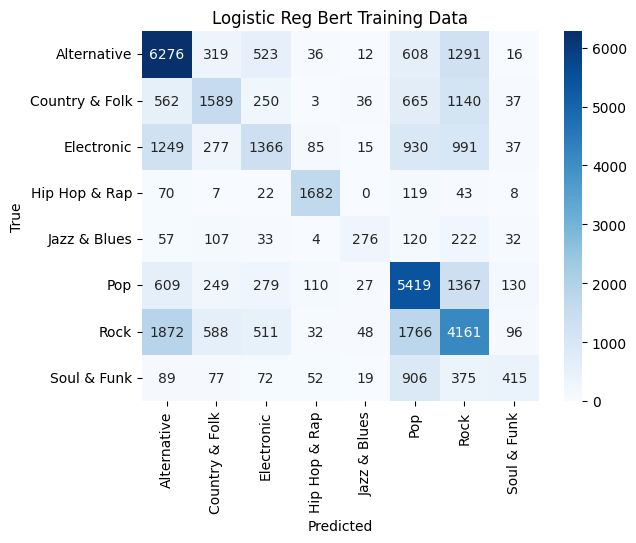

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cm = confusion_matrix(train_label, train_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg Bert Training Data')
plt.show()

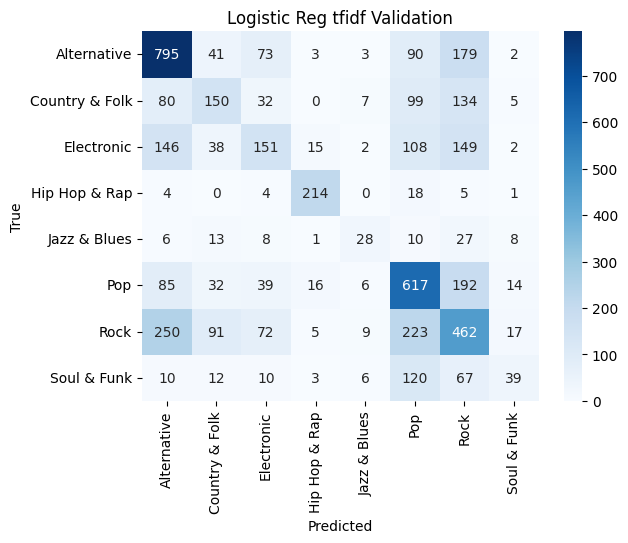

In [22]:
cm = confusion_matrix(validation_label, val_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Validation')
plt.show()

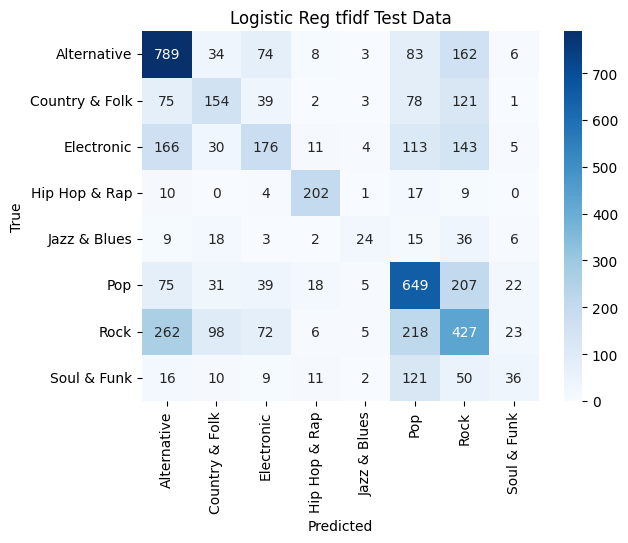

In [23]:
cm = confusion_matrix(test_label, test_predict)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encode_label.classes_, yticklabels=encode_label.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Reg tfidf Test Data')
plt.show()